# Singapore Job Market: Data Cleaning & Exploratory Data Analysis
## NTU DSAI Module 1 Capstone Project

This notebook captures the end-to-end data cleaning and exploratory data analysis process for the Singapore Job Market Analytics project. Our goal is to prepare the data for building a dashboard that helps identify structural misalignments in the Singapore job market for economic sustainability.

## Section 1: Import Required Libraries
Import necessary libraries for data manipulation, visualization, and analysis.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ast
import json
import re
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Section 2: Load and Inspect the Dataset
Load the CSV file into a pandas DataFrame and perform initial inspection.

In [2]:
# Load the dataset
# Using SGJobData.csv which contains ~1.1M+ job postings from Singapore
file_path = "SGJobData.csv"

print(f"Loading dataset from {file_path}...")
df = pd.read_csv(file_path)
print(f"✓ Dataset loaded successfully!")

# Display basic dataset information
print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn Names and Data Types:")
print(df.dtypes)

# Display first few rows
print(f"\nFirst 5 rows of the dataset:")
df.head()


Loading dataset from SGJobData.csv...
✓ Dataset loaded successfully!

Dataset Shape: 1,048,585 rows × 22 columns

Column Names and Data Types:
categories                             object
employmentTypes                        object
metadata_expiryDate                    object
metadata_isPostedOnBehalf                bool
metadata_jobPostId                     object
metadata_newPostingDate                object
metadata_originalPostingDate           object
metadata_repostCount                    int64
metadata_totalNumberJobApplication      int64
metadata_totalNumberOfView              int64
minimumYearsExperience                  int64
numberOfVacancies                       int64
occupationId                          float64
positionLevels                         object
postedCompany_name                     object
salary_maximum                          int64
salary_minimum                          int64
salary_type                            object
status_id                    

,categories,employmentTypes,metadata_expiryDate,metadata_isPostedOnBehalf,metadata_jobPostId,metadata_newPostingDate,metadata_originalPostingDate,metadata_repostCount,metadata_totalNumberJobApplication,metadata_totalNumberOfView,minimumYearsExperience,numberOfVacancies,occupationId,positionLevels,postedCompany_name,salary_maximum,salary_minimum,salary_type,status_id,status_jobStatus,title,average_salary
0,"[{""id"":13,""category"":""Environment / Health""},{""id"":25,""category"":""Manufacturing""},{""id"":36,""cate...",Permanent,2023-05-08,False,MCF-2023-0252866,2023-04-08,2023-03-30,2,5,151,0,1,NaN,Executive,WORKSTONE PTE. LTD.,2800,2000,Monthly,0,Closed,"Food Technologist - Clementi | Entry Level | Up to $2,800",2400.0
1,"[{""id"":21,""category"":""Information Technology""}]",Permanent,2023-05-08,False,MCF-2023-0273977,2023-04-08,2023-04-08,0,0,55,2,2,NaN,Executive,TRUST RECRUIT PTE. LTD.,5500,4000,Monthly,0,Closed,"Software Engineer (Fab Support) (Java, CIM, Up to $ 5.5K) - DS",4750.0
2,"[{""id"":33,""category"":""Repair and Maintenance""}]",Full Time,2023-04-22,False,MCF-2023-0273994,2023-04-08,2023-04-08,0,7,99,3,1,NaN,Senior Executive,PU TIEN SERVICES PTE. LTD.,4600,3800,Monthly,0,Closed,Senior Technician,4200.0
3,"[{""id"":21,""category"":""Information Technology""}]",Permanent,2023-05-08,False,MCF-2023-0273991,2023-04-08,2023-04-08,0,6,113,8,1,NaN,Senior Executive,TRUST RECRUIT PTE. LTD.,10000,5000,Monthly,0,Closed,"Senior .NET Developer (.NET Core, MVC, MVVC, SharePoint) - DS",7500.0
4,"[{""id"":2,""category"":""Admin / Secretarial""}]",Full Time,2023-05-08,False,MCF-2023-0273976,2023-04-08,2023-04-08,0,3,99,2,3,NaN,Non-executive,EATZ CATERING SERVICES PTE. LTD.,3400,2400,Monthly,0,Closed,Sales / Admin Cordinator,2900.0


Missing Values Summary (sorted by count):
                              Missing_Count  Missing_Percentage
occupationId                        1048585              100.00
categories                             3988                0.38
metadata_expiryDate                    3988                0.38
metadata_jobPostId                     3988                0.38
metadata_newPostingDate                3988                0.38
employmentTypes                        3988                0.38
status_jobStatus                       3988                0.38
metadata_originalPostingDate           3988                0.38
positionLevels                         3988                0.38
postedCompany_name                     3988                0.38
salary_type                            3988                0.38
title                                  3988                0.38


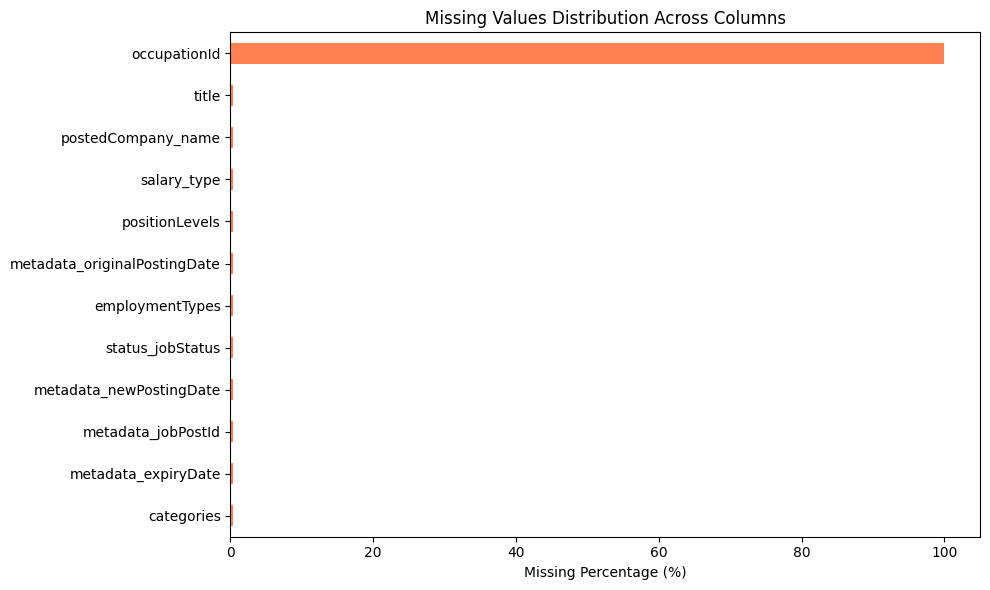

In [3]:
# Check for missing values
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct.round(2)
})

print("Missing Values Summary (sorted by count):")
print(missing_summary[missing_summary['Missing_Count'] > 0])

# Visualize missing data patterns
fig = plt.figure(figsize=(14, 6))
missing_summary[missing_summary['Missing_Count'] > 0]['Missing_Percentage'].sort_values().plot(
    kind='barh', color='coral', figsize=(10, 6)
)
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Values Distribution Across Columns')
plt.tight_layout()
plt.show()

## Section 3: Data Cleaning - Handle Missing Values
Remove columns with excessive missing data and drop rows with missing values in critical columns.

In [4]:
# Step 1: Strip column names to remove any leading/trailing whitespace
df.columns = df.columns.str.strip()
print("✓ Column names stripped of whitespace")

# Step 2: Identify and drop columns with excessive missing data
# occupationId is 100% null and status_id has only one unique value (0)
print("\nChecking for columns to drop:")
print(f"- occupationId missing: {df['occupationId'].isnull().sum() / len(df) * 100:.1f}%")
print(f"- status_id unique values: {df['status_id'].nunique()}")

columns_to_drop = ['occupationId', 'status_id']
df_clean = df.drop(columns=columns_to_drop)
print(f"\n✓ Dropped {len(columns_to_drop)} columns with no analytical value")

# Step 3: Drop rows with missing values in important columns
null_columns = [col for col in df_clean.columns if df_clean[col].isnull().sum() > 0]
print(f"\nColumns with missing values: {null_columns}")

initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=null_columns)
final_rows = len(df_clean)
rows_dropped = initial_rows - final_rows
pct_loss = (rows_dropped / initial_rows) * 100

print(f"\n✓ Dropped {rows_dropped:,} rows with missing values")
print(f"  Data retention: {final_rows:,} rows ({100-pct_loss:.2f}%)")

# Verify no missing values remain in critical columns
print(f"\nMissing values after cleaning: {df_clean[null_columns].isnull().sum().sum()}")
print(f"✓ Data cleaning complete! Final dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

✓ Column names stripped of whitespace

Checking for columns to drop:
- occupationId missing: 100.0%
- status_id unique values: 1

✓ Dropped 2 columns with no analytical value

Columns with missing values: ['categories', 'employmentTypes', 'metadata_expiryDate', 'metadata_jobPostId', 'metadata_newPostingDate', 'metadata_originalPostingDate', 'positionLevels', 'postedCompany_name', 'salary_type', 'status_jobStatus', 'title']

✓ Dropped 3,988 rows with missing values
  Data retention: 1,044,597 rows (99.62%)

Missing values after cleaning: 0
✓ Data cleaning complete! Final dataset: 1,044,597 rows × 20 columns


## Section 4: Data Cleaning - Standardize Categories and Formats
Standardize date columns, parse JSON categories, and clean salary data.

In [5]:
# Step 1: Standardize date columns
print("Converting date columns to datetime format...")
date_columns = ['metadata_expiryDate', 'metadata_newPostingDate', 'metadata_originalPostingDate']
for col in date_columns:
    df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

print("✓ Date columns converted")

# Step 2: Parse JSON categories column
print("\nParsing categories JSON column...")

def safe_parse_categories(cat_str):
    """Safely parse categories JSON string"""
    if isinstance(cat_str, str):
        try:
            return json.loads(cat_str) if cat_str else []
        except:
            return []
    return cat_str if isinstance(cat_str, list) else []

df_clean['categories'] = df_clean['categories'].apply(safe_parse_categories)

# Extract primary category from parsed JSON
def extract_primary_category(categories):
    """Extract the primary (first) category name from parsed categories"""
    if categories and len(categories) > 0 and isinstance(categories, list):
        first_cat = categories[0]
        if isinstance(first_cat, dict) and 'category' in first_cat:
            return first_cat['category']
    return "Unknown"

df_clean['primary_category'] = df_clean['categories'].apply(extract_primary_category)

print(f"✓ Categories parsed. Found {df_clean['primary_category'].nunique()} unique categories")
print(f"\nTop 10 Job Categories:")
print(df_clean['primary_category'].value_counts().head(10))

# Step 3: Standardize salary data
print("\n\nStandardizing salary columns...")
print(f"Salary minimum range: ${df_clean['salary_minimum'].min():,.0f} - ${df_clean['salary_minimum'].max():,.0f}")
print(f"Salary maximum range: ${df_clean['salary_maximum'].min():,.0f} - ${df_clean['salary_maximum'].max():,.0f}")

# Create average salary column
df_clean['average_salary'] = (df_clean['salary_minimum'] + df_clean['salary_maximum']) / 2
print("✓ Average salary column created")

# Step 4: Check employment types
print(f"\n\nUnique Employment Types: {df_clean['employmentTypes'].nunique()}")
print(df_clean['employmentTypes'].value_counts())

Converting date columns to datetime format...
✓ Date columns converted

Parsing categories JSON column...
✓ Categories parsed. Found 43 unique categories

Top 10 Job Categories:
primary_category
Admin / Secretarial                 102719
Information Technology              100142
Engineering                          99675
Accounting / Auditing / Taxation     78648
Building and Construction            74014
Customer Service                     64865
F&B                                  59678
Banking and Finance                  46635
Logistics / Supply Chain             44391
Sales / Retail                       37313
Name: count, dtype: int64


Standardizing salary columns...
Salary minimum range: $1 - $350,000
Salary maximum range: $1 - $25,330,000
✓ Average salary column created


Unique Employment Types: 8
employmentTypes
Permanent                458139
Full Time                393352
Contract                 139182
Part Time                 25431
Temporary                 18241
Int

## Section 5: Feature Engineering - Create Derived Columns
Create new features for time-based analysis, salary bands, and demand metrics.

In [6]:
# Step 1: Create month-year column for time-based analysis
print("Creating time-based features...")
df_clean['month_year'] = df_clean['metadata_originalPostingDate'].dt.to_period('M').dt.to_timestamp()
df_clean['year'] = df_clean['metadata_originalPostingDate'].dt.year
df_clean['month'] = df_clean['metadata_originalPostingDate'].dt.month
print("✓ Month-year, year, and month columns created")

# Step 2: Create salary bands
print("\nCreating salary bands...")
df_clean['salary_band'] = pd.cut(df_clean['average_salary'], 
                                  bins=[0, 3000, 5000, 7000, 10000, 20000, float('inf')],
                                  labels=['Below 3K', '3K-5K', '5K-7K', '7K-10K', '10K-20K', 'Above 20K'])
print("✓ Salary band column created")
print(df_clean['salary_band'].value_counts().sort_index())

# Step 3: Create metrics for market demand analysis
print("\n\nCreating demand metrics...")

# Applications per vacancy ratio
df_clean['apps_per_vacancy'] = df_clean['metadata_totalNumberJobApplication'] / df_clean['numberOfVacancies']
df_clean['apps_per_vacancy'] = df_clean['apps_per_vacancy'].replace([np.inf, -np.inf], np.nan)

# Views per application ratio
df_clean['views_per_application'] = df_clean['metadata_totalNumberOfView'] / df_clean['metadata_totalNumberJobApplication']
df_clean['views_per_application'] = df_clean['views_per_application'].replace([np.inf, -np.inf], np.nan)

print("✓ Demand metrics created:")
print(f"  - Apps per vacancy (average): {df_clean['apps_per_vacancy'].mean():.2f}")
print(f"  - Views per application (average): {df_clean['views_per_application'].mean():.2f}")

# Step 4: Extract keyword features from job titles
print("\n\nExtracting job title features...")

def extract_seniority(title):
    """Extract seniority level from job title"""
    title_lower = str(title).lower()
    senior_keywords = ['senior', 'sr ', 'lead', 'principal', 'manager', 'director', 'head', 'chief']
    junior_keywords = ['junior', 'jr ', 'trainee', 'graduate', 'assistant']
    
    for keyword in senior_keywords:
        if keyword in title_lower:
            return 'Senior'
    for keyword in junior_keywords:
        if keyword in title_lower:
            return 'Junior'
    return 'Mid-level'

df_clean['seniority_level'] = df_clean['title'].apply(extract_seniority)
print("✓ Seniority level extracted from job titles")
print(df_clean['seniority_level'].value_counts())

# Step 5: Log-transformed salary for visualization
print("\n\nCreating log-transformed salary...")
df_clean['log_salary'] = np.log1p(df_clean['average_salary'])
print("✓ Log-transformed salary created for better visualization")

print(f"\n\n✓ Feature engineering complete!")
print(f"Final cleaned dataset: {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns")

Creating time-based features...
✓ Month-year, year, and month columns created

Creating salary bands...
✓ Salary band column created
salary_band
Below 3K     307517
3K-5K        445146
5K-7K        138140
7K-10K        99698
10K-20K       50114
Above 20K      3982
Name: count, dtype: int64


Creating demand metrics...
✓ Demand metrics created:
  - Apps per vacancy (average): 1.67
  - Views per application (average): 16.57


Extracting job title features...
✓ Seniority level extracted from job titles
seniority_level
Mid-level    680867
Senior       262016
Junior       101714
Name: count, dtype: int64


Creating log-transformed salary...
✓ Log-transformed salary created for better visualization


✓ Feature engineering complete!
Final cleaned dataset: 1,044,597 rows × 29 columns


## Section 6: Exploratory Data Analysis - Key Distributions
Analyze distributions of key variables and identify patterns in the job market.

SUMMARY STATISTICS - Numeric Columns
       metadata_repostCount  metadata_totalNumberJobApplication  \
count            1044597.00                          1044597.00   
mean                   0.05                                2.14   
std                    0.28                               10.65   
min                    0.00                                0.00   
25%                    0.00                                0.00   
50%                    0.00                                0.00   
75%                    0.00                                1.00   
max                    2.00                             1342.00   

       metadata_totalNumberOfView  minimumYearsExperience  numberOfVacancies  \
count                  1044597.00              1044597.00         1044597.00   
mean                        26.85                    2.79               2.69   
std                         82.76                    2.54              11.26   
min                          0.00      

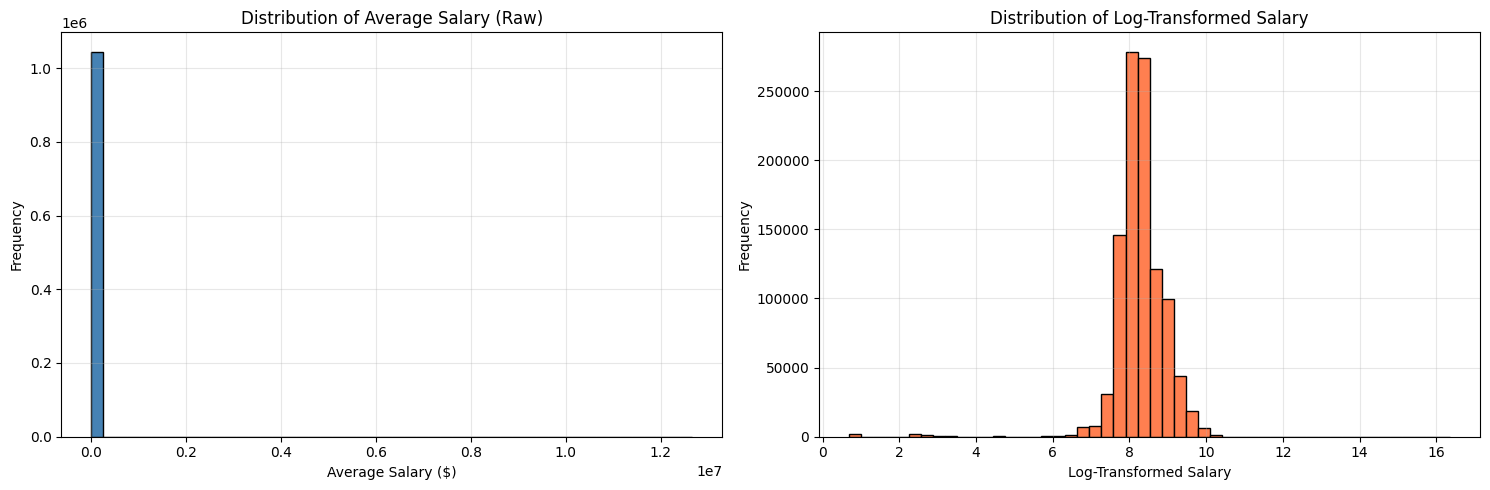


Salary Statistics:
  Mean: $4,787.65
  Median: $3,800.00
  Std Dev: $25,524.97
  Range: $1 - $12,666,400


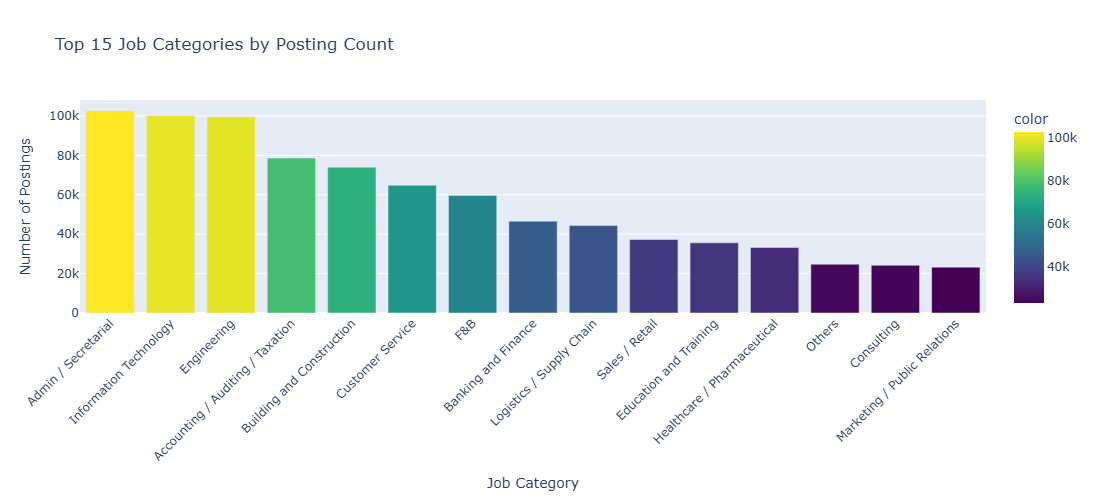

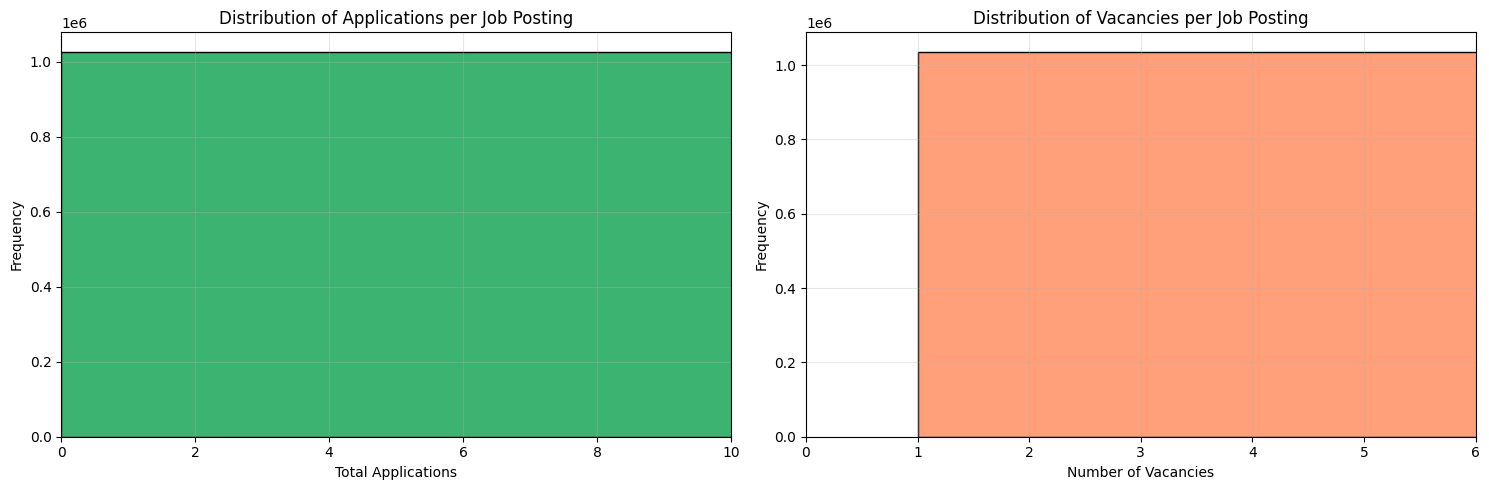

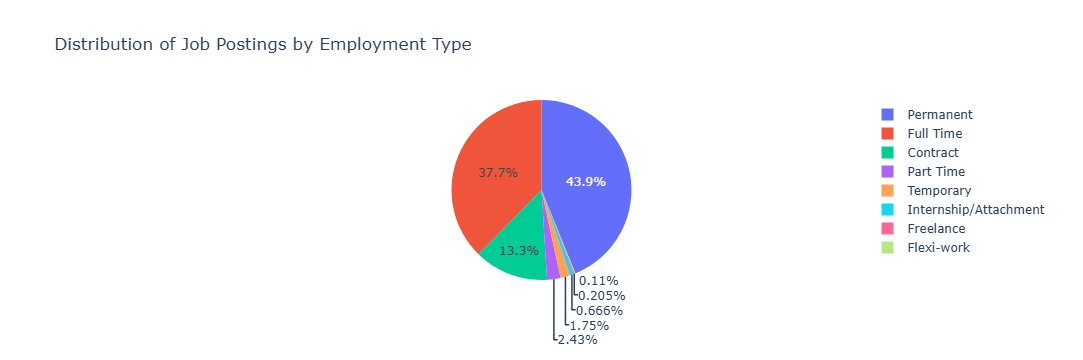

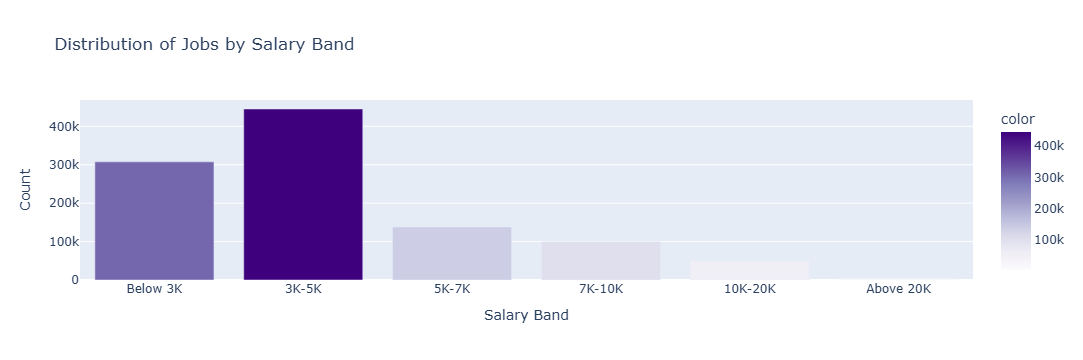

In [7]:
# 6.1: Summary statistics for numeric columns
print("=" * 80)
print("SUMMARY STATISTICS - Numeric Columns")
print("=" * 80)
numeric_summary = df_clean.select_dtypes(['int', 'float']).describe().round(2)
print(numeric_summary)

# 6.2: Distribution of salary
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_clean['average_salary'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Average Salary ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Average Salary (Raw)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_clean['log_salary'], bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Log-Transformed Salary')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Salary')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSalary Statistics:")
print(f"  Mean: ${df_clean['average_salary'].mean():,.2f}")
print(f"  Median: ${df_clean['average_salary'].median():,.2f}")
print(f"  Std Dev: ${df_clean['average_salary'].std():,.2f}")
print(f"  Range: ${df_clean['average_salary'].min():,.0f} - ${df_clean['average_salary'].max():,.0f}")

# 6.3: Top job categories
top_categories = df_clean['primary_category'].value_counts().head(15)
fig = px.bar(x=top_categories.index, y=top_categories.values, 
             title='Top 15 Job Categories by Posting Count',
             labels={'x': 'Job Category', 'y': 'Number of Postings'},
             color=top_categories.values, 
             color_continuous_scale='Viridis')
fig.update_layout(height=500, xaxis_tickangle=-45)
fig.show()

# 6.4: Distribution of applications per posting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_clean['metadata_totalNumberJobApplication'], bins=50, color='mediumseagreen', edgecolor='black')
axes[0].set_xlabel('Total Applications')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Applications per Job Posting')
axes[0].set_xlim(0, df_clean['metadata_totalNumberJobApplication'].quantile(0.95))
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_clean['numberOfVacancies'], bins=50, color='lightsalmon', edgecolor='black')
axes[1].set_xlabel('Number of Vacancies')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Vacancies per Job Posting')
axes[1].set_xlim(0, df_clean['numberOfVacancies'].quantile(0.95))
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6.5: Employment type distribution
emp_type_dist = df_clean['employmentTypes'].value_counts()
fig = px.pie(values=emp_type_dist.values, names=emp_type_dist.index,
             title='Distribution of Job Postings by Employment Type')
fig.show()

# 6.6: Salary band distribution
salary_band_dist = df_clean['salary_band'].value_counts().sort_index()
fig = px.bar(x=salary_band_dist.index, y=salary_band_dist.values,
             title='Distribution of Jobs by Salary Band',
             labels={'x': 'Salary Band', 'y': 'Count'},
             color=salary_band_dist.values,
             color_continuous_scale='Purples')
fig.show()

## Section 7: Exploratory Data Analysis - Relationships and Trends
Analyze correlations between variables and identify market trends over time.

CORRELATION ANALYSIS - Pay, Applications & Market Metrics
                                    average_salary  \
average_salary                               1.000   
metadata_totalNumberJobApplication           0.180   
metadata_totalNumberOfView                   0.098   
numberOfVacancies                            0.101   

                                    metadata_totalNumberJobApplication  \
average_salary                                                   0.180   
metadata_totalNumberJobApplication                               1.000   
metadata_totalNumberOfView                                       0.864   
numberOfVacancies                                                0.021   

                                    metadata_totalNumberOfView  \
average_salary                                           0.098   
metadata_totalNumberJobApplication                       0.864   
metadata_totalNumberOfView                               1.000   
numberOfVacancies                   

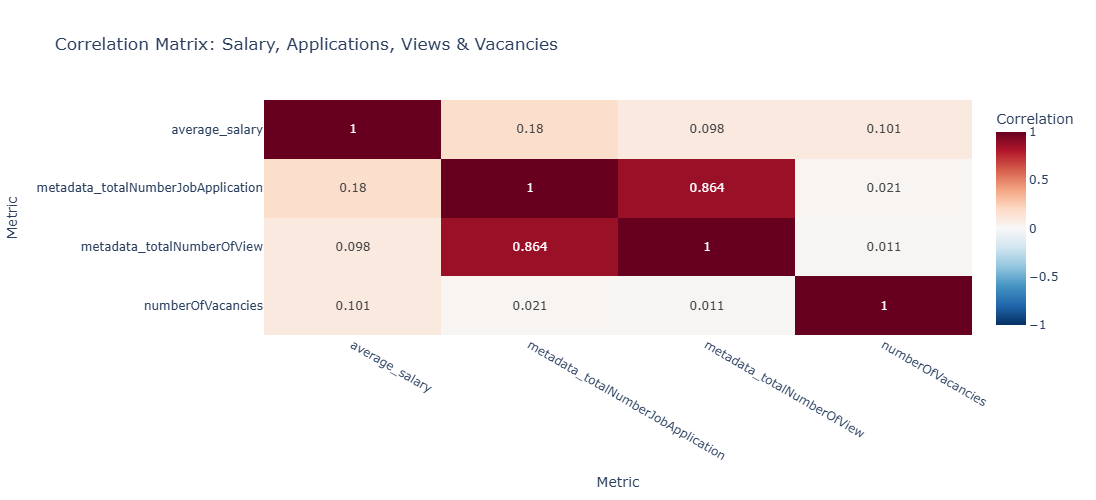


SALARY ANALYSIS BY JOB CATEGORY

Top 15 Highest-Paying Job Categories (min. 10 postings):
                                 count     mean  median        std
primary_category                                                  
Legal                             3502  8790.89  7000.0   11629.83
Risk Management                   1102  8542.77  6500.0    8813.83
Banking and Finance              46635  7694.71  6250.0    6752.54
Information Technology          100142  7307.91  6750.0    4637.26
Consulting                       24187  6814.09  5000.0   51047.91
Insurance                         3219  6610.09  5250.0    6249.17
General Management               13696  6364.73  4250.0   35126.52
Telecommunications                 885  6278.92  4250.0   12923.10
Medical / Therapy Services        4052  6049.25  4000.0   78557.79
Architecture / Interior Design   14663  5405.24  4000.0   97960.01
Professional Services             3654  5304.39  4250.0    5921.96
Sciences / Laboratory / R&D      10387

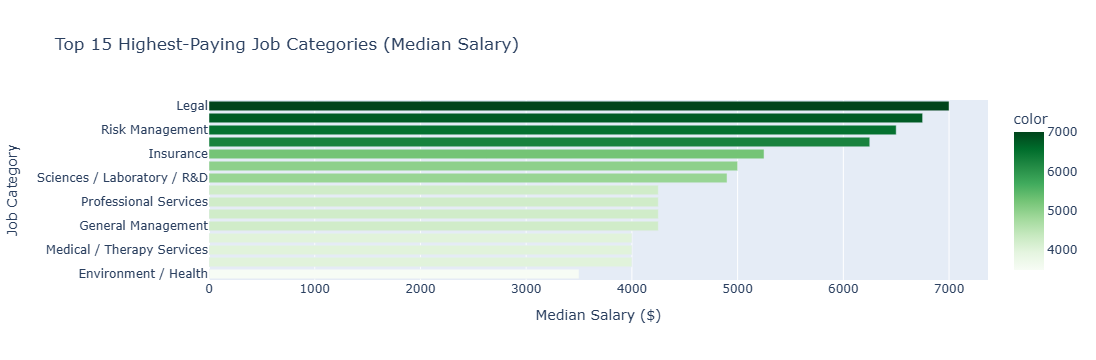


MARKET DEMAND ANALYSIS - Applications & Vacancies by Category

Top 15 Job Categories by Average Applications per Posting:
                                   metadata_totalNumberJobApplication  \
primary_category                                                        
Social Services                                              4.549612   
Risk Management                                              3.804900   
Banking and Finance                                          3.764297   
Human Resources                                              3.559752   
Travel / Tourism                                             3.511044   
Design                                                       3.335471   
General Management                                           3.328271   
Real Estate / Property Management                            3.261969   
Wholesale Trade                                              3.123452   
Advertising / Media                                          3.080427   
M

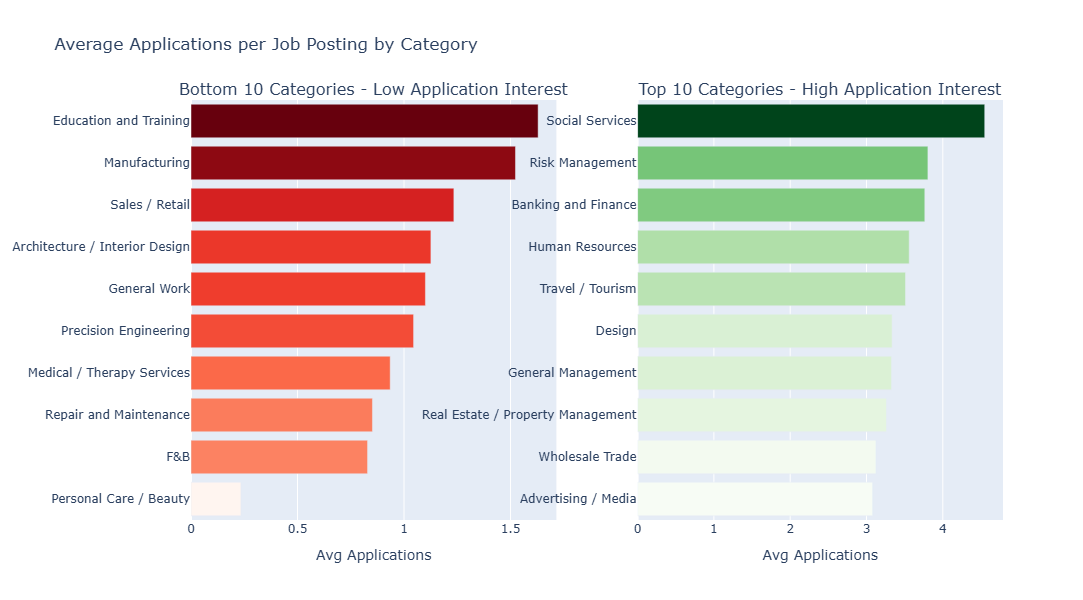


TEMPORAL TRENDS - Job Market Dynamics Over Time

Monthly Trend Summary (first 10 months):
  month_year  job_postings  total_applications  total_vacancies   avg_salary
0 2022-10-01           172                2953              413  4184.424419
1 2022-11-01           590               10514             1494  4468.802542
2 2022-12-01          1184               21006             3120  4413.698480
3 2023-01-01          2764               50888             8318  6802.556440
4 2023-02-01          5855              114639            16948  4267.068318
5 2023-03-01         19414              246845            55974  4996.016277
6 2023-04-01         33094              351882            82122  4593.968106
7 2023-05-01         70213              706806           180009  4702.012263
8 2023-06-01         70410              439994           187225  4665.018286
9 2023-07-01         82878               19871           210670  4703.832706


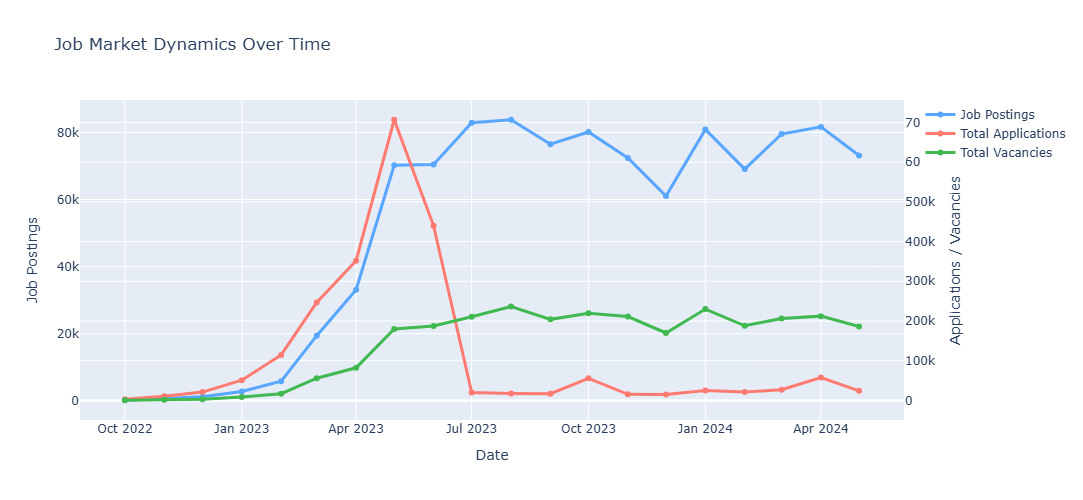


SENIORITY LEVEL ANALYSIS

Distribution of Job Postings by Seniority Level:
seniority_level
Mid-level    680867
Senior       262016
Junior       101714
Name: count, dtype: int64

Salary by Seniority Level:
                  count     mean  median
seniority_level                         
Senior           262016  6995.56  6000.0
Mid-level        680867  4210.88  3500.0
Junior           101714  2960.98  2600.0


In [8]:
# 7.1: Correlation analysis
print("=" * 80)
print("CORRELATION ANALYSIS - Pay, Applications & Market Metrics")
print("=" * 80)

correlation_cols = ['average_salary', 'metadata_totalNumberJobApplication', 
                    'metadata_totalNumberOfView', 'numberOfVacancies']
corr_matrix = df_clean[correlation_cols].corr().round(3)
print(corr_matrix)

# Visualize correlation heatmap
fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='RdBu_r',
                 title='Correlation Matrix: Salary, Applications, Views & Vacancies',
                 labels=dict(x='Metric', y='Metric', color='Correlation'),
                 zmin=-1, zmax=1, aspect='auto')
fig.update_layout(height=500, width=600)
fig.show()

# 7.2: Salary by job category
print("\n" + "=" * 80)
print("SALARY ANALYSIS BY JOB CATEGORY")
print("=" * 80)

category_salary = df_clean.groupby('primary_category')['average_salary'].agg(['count', 'mean', 'median', 'std']).round(2)
category_salary = category_salary[category_salary['count'] >= 10].sort_values('mean', ascending=False)
print("\nTop 15 Highest-Paying Job Categories (min. 10 postings):")
print(category_salary.head(15))

# Visualize top 15 highest-paying categories
top_paying = category_salary.head(15).sort_values('median')
fig = px.bar(x=top_paying['median'], y=top_paying.index,
             title='Top 15 Highest-Paying Job Categories (Median Salary)',
             labels={'x': 'Median Salary ($)', 'y': 'Job Category'},
             color=top_paying['median'],
             color_continuous_scale='Greens',
             orientation='h')
fig.show()

# 7.3: Applications by job category - Market demand analysis
print("\n" + "=" * 80)
print("MARKET DEMAND ANALYSIS - Applications & Vacancies by Category")
print("=" * 80)

category_demand = df_clean.groupby('primary_category').agg({
    'metadata_totalNumberJobApplication': 'mean',
    'numberOfVacancies': 'mean',
    'apps_per_vacancy': 'mean',
    'primary_category': 'count'
}).rename(columns={'primary_category': 'posting_count'})

category_demand = category_demand[category_demand['posting_count'] >= 10].sort_values('metadata_totalNumberJobApplication', ascending=False)
print("\nTop 15 Job Categories by Average Applications per Posting:")
print(category_demand.head(15))

# Visualize bottom vs top categories by average applications
avg_apps_global = df_clean.groupby('primary_category')['metadata_totalNumberJobApplication'].mean().sort_values()
bottom_10 = avg_apps_global.head(10)
top_10 = avg_apps_global.tail(10)

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=("Bottom 10 Categories - Low Application Interest",
                                   "Top 10 Categories - High Application Interest"))

fig.add_trace(go.Bar(x=bottom_10.values, y=bottom_10.index, orientation='h', 
                     marker=dict(color=bottom_10.values, colorscale='Reds', showscale=False),
                     name='Bottom 10'), row=1, col=1)

fig.add_trace(go.Bar(x=top_10.values, y=top_10.index, orientation='h',
                     marker=dict(color=top_10.values, colorscale='Greens', showscale=False),
                     name='Top 10'), row=1, col=2)

fig.update_layout(height=600, title_text="Average Applications per Job Posting by Category",
                  showlegend=False)
fig.update_xaxes(title_text="Avg Applications", row=1, col=1)
fig.update_xaxes(title_text="Avg Applications", row=1, col=2)
fig.show()

# 7.4: Time series analysis - Job postings over time
print("\n" + "=" * 80)
print("TEMPORAL TRENDS - Job Market Dynamics Over Time")
print("=" * 80)

monthly_trend = df_clean.groupby('month_year').agg({
    'month_year': 'count',
    'metadata_totalNumberJobApplication': 'sum',
    'numberOfVacancies': 'sum',
    'average_salary': 'mean'
}).rename(columns={
    'month_year': 'job_postings',
    'metadata_totalNumberJobApplication': 'total_applications',
    'numberOfVacancies': 'total_vacancies',
    'average_salary': 'avg_salary'
}).reset_index()

print(f"\nMonthly Trend Summary (first 10 months):")
print(monthly_trend.head(10))

# Visualize time series trends
fig = go.Figure()

fig.add_trace(go.Scatter(x=monthly_trend['month_year'], y=monthly_trend['job_postings'],
                        mode='lines+markers', name='Job Postings',
                        line=dict(color='#58a6ff', width=3)))
fig.add_trace(go.Scatter(x=monthly_trend['month_year'], y=monthly_trend['total_applications'],
                        mode='lines+markers', name='Total Applications',
                        yaxis='y2', line=dict(color='#ff7b72', width=3)))
fig.add_trace(go.Scatter(x=monthly_trend['month_year'], y=monthly_trend['total_vacancies'],
                        mode='lines+markers', name='Total Vacancies',
                        yaxis='y2', line=dict(color='#3fb950', width=3)))

fig.update_layout(
    title='Job Market Dynamics Over Time',
    xaxis_title='Date',
    yaxis=dict(title='Job Postings', showgrid=True),
    yaxis2=dict(title='Applications / Vacancies', overlaying='y', side='right'),
    hovermode='x unified',
    height=500, width=1000
)
fig.show()

# 7.5: Seniority level analysis
print("\n" + "=" * 80)
print("SENIORITY LEVEL ANALYSIS")
print("=" * 80)

seniority_dist = df_clean['seniority_level'].value_counts()
print(f"\nDistribution of Job Postings by Seniority Level:")
print(seniority_dist)

seniority_salary = df_clean.groupby('seniority_level')['average_salary'].agg(['count', 'mean', 'median']).round(2).sort_values('median', ascending=False)
print(f"\nSalary by Seniority Level:")
print(seniority_salary)

In [9]:
# Save the cleaned dataset for future use in dashboard development
print("\nSaving cleaned dataset...")
output_path = "SGJobData_cleaned_processed.csv"
df_clean.to_csv(output_path, index=False)
print(f"✓ Cleaned dataset saved to: {output_path}")
print(f"✓ File size: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Also display final dataset info
print(f"\nFINAL PROCESSED DATASET INFORMATION:")
print(f"Shape: {df_clean.shape}")
print(f"\nColumns available for dashboard analysis:")
columns_list = df_clean.columns.tolist()
for i, col in enumerate(columns_list, 1):
    print(f"  {i:2d}. {col}")


Saving cleaned dataset...
✓ Cleaned dataset saved to: SGJobData_cleaned_processed.csv
✓ File size: 814.29 MB

FINAL PROCESSED DATASET INFORMATION:
Shape: (1044597, 29)

Columns available for dashboard analysis:
   1. categories
   2. employmentTypes
   3. metadata_expiryDate
   4. metadata_isPostedOnBehalf
   5. metadata_jobPostId
   6. metadata_newPostingDate
   7. metadata_originalPostingDate
   8. metadata_repostCount
   9. metadata_totalNumberJobApplication
  10. metadata_totalNumberOfView
  11. minimumYearsExperience
  12. numberOfVacancies
  13. positionLevels
  14. postedCompany_name
  15. salary_maximum
  16. salary_minimum
  17. salary_type
  18. status_jobStatus
  19. title
  20. average_salary
  21. primary_category
  22. month_year
  23. year
  24. month
  25. salary_band
  26. apps_per_vacancy
  27. views_per_application
  28. seniority_level
  29. log_salary


In [10]:
# Compress the cleaned dataset separately with gzip to facilitate GitHub Upload & Cloud deployment
compressed_output_path = "SGJobData_cleaned_processed_compressed.csv.gz"
df_clean.to_csv(compressed_output_path, index=False, compression="gzip")